### Contents
1. [Preprocessing](#Preprocessing)
2. [Feature Construction](#Feature-Construction)
3. [Cross Validation Strategy](#Cross-Validation-Strategy)
4. [Training](#Training)
    * 4.1 [Multistep-ahead Prediction Strategy](#Multistep-ahead-Prediction-Strategy)
    * 4.2 [Training Procedure](#Training-Procedure)
    * 4.3 [CV Layout](#CV-Layout)
    * 4.4 [ParamGridIter](#ParamGridIter)
    * 4.5 [Start](#Start)
5. [Intermediate Results I](#Intermediate-Results-I)  
    * 5.1 [Training (Evaluation On)](#Training-(Evaluation-On))  
    * 5.2 [Loss Curves](#Loss-Curves)  
    * 5.3 [Possible Remedies](#Possible-Remedies)
6. [Intermediate Results II](#Intermediate-Results-II)
7. [Uncertainty](#Uncertainty)
8. [Prediction Plots](#Prediction-Plots)  
    * 8.1 [Predictions: Last (4th) Fold](#Predictions:-Last-(4th)-Fold)  
    * 8.2 [Predictions: 3rd Fold](#Predictions:-3rd-Fold)  
    * 8.3 [Predictions: 2nd Fold](#Predictions:-2nd-Fold)
    * 8.4 [Predictions: 1st Fold](#Predictions:-1st-Fold)
9. [Future Work](#Future-Work)

In [ ]:
# in case you are using kaggle kernel
#
# ! mkdir site-packages && pip install -U git+https://github.com/forveg/utils.git@dev --target /kaggle/working/site-packages
#
# import sys
# sys.path.insert(0, '/kaggle/working/site-packages')

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json

In [3]:
plt.rcParams.update({'font.size': 8})
plt.style.use('seaborn-v0_8-darkgrid')

First we preprocess data, applying all the steps, mentioned in EDA

### Preprocessing
[[To the top]](#Contents)

In [9]:
def process(path: str) -> pd.DataFrame:
    """Preprocessing of the energy dataset
    """
    new_names = ['date', 
             'price_zone', 
             'free_transfer_zone', 
             'hour', 
             'hydro_plan',
             'nuclear_plan', 
             'thermal_plan', 
             'thermal_min', 
             'thermal_max',
             'consumption', 
             'export',
             'import',
             'solar_plan',
             'wind_plan',
             'renewable_plan',
             'supply_1',
             'supply_2',
             'price',
            ]
    
    # haven't figured out how to rename *multilevel* columns in a functional way
    def rename(df):
        df.columns = [f'{col[1]}_{col[0]}' for col in df.columns]
        return df
    
    # zero variance threshold
    variance_eps = 1e-6
    
    df = ( pd
      .read_csv(path)
      
       # rename columns for better access/readability
      .pipe(lambda df: df.rename(columns = dict(zip(df.columns, new_names))))
       
       # casting/shrinking
      .astype({'date': 'datetime64[ns]',
               'free_transfer_zone': 'category',
               'hour': 'int8'})
      .pipe(lambda df: df.astype({ col: 'float32' 
                                  for col in df.select_dtypes('float64').columns }))
      
      # drop zero-variance features
      .drop(columns = ['price_zone',
                       'renewable_plan'])
      
      # removing trailing spaces
      .pipe(lambda df: df.assign(free_transfer_zone =
              df.free_transfer_zone.cat.rename_categories(lambda s: s.strip())))
      
      # combining hours and dates into a single feature
      .pipe(lambda df: df.assign( dtime = df['date'] + pd.to_timedelta(df.hour, unit='hour')))
      
      .drop(columns = ['date', 'hour'])
            
      .pivot(index='dtime', columns='free_transfer_zone')
      .sort_index()
            
      .pipe(lambda df: df.drop(columns = df.columns[df.std(axis=0)<variance_eps]))
        
      .pipe(rename)
      #.pipe(lambda df: df.columns = [f'{col[1]}_{col[0]}' for col in df.columns])  
    )
    return df

In [10]:
df = process('/kaggle/input/all-energy-v0/all_energy.csv')

In [11]:
df

FZSZKO28_hydro_plan  FZSZOE27_hydro_plan  \
dtime                                                           
2018-01-01 00:00:00                659.0           875.099976   
2018-01-01 01:00:00                612.0           872.099976   
2018-01-01 02:00:00                585.0           859.099976   
2018-01-01 03:00:00                585.0           859.099976   
2018-01-01 04:00:00                575.0           859.099976   
...                                  ...                  ...   
2020-08-24 19:00:00                671.0           837.599976   
2020-08-24 20:00:00                690.0           852.599976   
2020-08-24 21:00:00                712.0           860.599976   
2020-08-24 22:00:00                680.0           837.599976   
2020-08-24 23:00:00                646.0           802.599976   

                     FZURKR12_hydro_plan  FZUROE07_hydro_plan  \
dtime                                                           
2018-01-01 00:00:00                503.0            86.599998   
2018-01-01 01:00:00                310.0            86.599998   
2018-01-01 02:00:00                210.0            86.599998   
2018-01-01 03:00:00                210.0            86.599998   
2018-01-01 04:00:00                230.0            86.599998   
...                                  ...                  ...   
2020-08-24 19:00:00                482.0           557.388977   
2020-08-24 20:00:00                482.0           390.489014   
2020-08-24 21:00:00                482.0           267.000000   
2020-08-24 22:00:00                482.0           240.000000   
2020-08-24 23:00:00                482.0           240.000000   

                     FZVLBS15_hydro_plan  FZVLOE13_hydro_plan  \
dtime                                                           
2018-01-01 00:00:00           559.336975                500.0   
2018-01-01 01:00:00           120.000000                500.0   
2018-01-01 02:00:00           120.000000                500.0   
2018-01-01 03:00:00           120.000000                500.0   
2018-01-01 04:00:00           120.000000                500.0   
...                                  ...                  ...   
2020-08-24 19:00:00          1031.904053               1610.0   
2020-08-24 20:00:00          1000.848999               1610.0   
2020-08-24 21:00:00           968.060974               1610.0   
2020-08-24 22:00:00           400.000000               1560.0   
2020-08-24 23:00:00           400.000000               1526.0   

                     FZYUDA23_hydro_plan  FZYUKU20_hydro_plan  \
dtime                                                           
2018-01-01 00:00:00           260.562988            57.400002   
2018-01-01 01:00:00           153.955002            57.400002   
2018-01-01 02:00:00            66.584000            57.400002   
2018-01-01 03:00:00            59.000000            57.400002   
2018-01-01 04:00:00            59.000000            57.400002   
...                                  ...                  ...   
2020-08-24 19:00:00           976.333984           105.699997   
2020-08-24 20:00:00           595.000000           105.699997   
2020-08-24 21:00:00           795.000000             6.200000   
2020-08-24 22:00:00           695.000000             6.200000   
2020-08-24 23:00:00           605.000000             6.200000   

                     FZYUOE16_hydro_plan  FZYUVG17_hydro_plan  ...  \
dtime                                                          ...   
2018-01-01 00:00:00            47.369999          1448.786011  ...   
2018-01-01 01:00:00            47.369999           983.822021  ...   
2018-01-01 02:00:00            47.369999           920.000000  ...   
2018-01-01 03:00:00            47.369999           720.000000  ...   
2018-01-01 04:00:00            47.369999           720.000000  ...   
...                                  ...                  ...  ...   
2020-08-24 19:00:00           698.788025          1238.786987  ...   
2020-08

As we've seen earlier, target series display nonstationary behavior. Nonstationarity poses a problem for gradient boosting models:
1. Features on the test set, that fall outside their training set ranges, would be less informative (however extreme the value is, it would affect splitting decision in the same way)   
2. Targets on the test set, that fall far off their training ranges, could be unreachable

To alleviate those issues I use relative values: predict target differences instead of level values, and use differenced features

### Feature Construction
[[To the top]](#Contents)  
Most features are relative too (a difference between an aggregate and a current level)

In [12]:
from utils.preproc import add_features

In [8]:
add_features??

Signature: add_features(df: pandas.core.frame.DataFrame, **kw) -> pandas.core.frame.DataFrame
Source:   
def add_features(df: pd.DataFrame, **kw) -> pd.DataFrame:
    """Adds to the dataframe basic aggregate features, specified in kwargs
    
    Parameters
    ----------
    df : pd.DataFrame
        Source data
    kw : dict
        Dict of the following format (all keys mandatory, except for 'ewm_alphas'):
        feats = {
            'windows': [6, 12, 15, 120],
            'agg_func': ['max', 'median'],
            'ewm_alphas': [0.1, 0.5],
            'columns': ['price', 'sales_1', 'sales_2'],
        }
    
    """
    def agg_format(fun): 
        return str(fun).split(' ')[1]
    cols = kw['columns']
    
    agg_map = { 'min': np.min,
                'max': np.max,
                'median': np.median,
                'mean': np.mean,
                'std': np.std,
              }
    agg_func = [ agg_map[agg_str] for agg_str in kw['agg_func']]
    
    # level aggs
    df =

Here's a basic feature set

In [13]:
feats = {
    'windows': [6, 24, 24*7, 24*7*4],
    'agg_func': [
        'median', 
        'max',
        'min', 
        'std',
    ],
    'ewm_alphas': [0.4, 0.6, 0.8],
    'columns': list(df.columns),
}

with open('feats.json', 'w') as f:
    json.dump(feats, f)

In [14]:
df = add_features(df, **feats)

/kaggle/working/site-packages/utils/preproc.py:112: FutureWarning: The provided callable <function median at 0x7a3f743efd90> is currently using Rolling.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  .aggregate(agg)
/kaggle/working/site-packages/utils/preproc.py:112: FutureWarning: The provided callable <function max at 0x7a3f746c3d00> is currently using Rolling.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  .aggregate(agg)
/kaggle/working/site-packages/utils/preproc.py:112: FutureWarning: The provided callable <function min at 0x7a3f746c3e20> is currently using Rolling.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  .aggregate(agg)
/kaggle/working/site-packages/utils/preproc.py:112: FutureWarning: The provided

In [15]:
df.shape

(23208, 3244)

In [16]:
zones = [ col.split('_')[0] for col in df.columns if col.endswith('price')]
target = 'FZYUAS18_price'

zones

['FZSZKO28',
 'FZSZOE27',
 'FZURKR12',
 'FZURNT09',
 'FZUROE07',
 'FZURTU08',
 'FZVLBS15',
 'FZVLOE13',
 'FZYUAS18',
 'FZYUDA23',
 'FZYUKU20',
 'FZYUOE16',
 'FZYUVG17',
 'FZZMSK26',
 'FZZNOE24']

tsfresh library offers a rich suit of time-series features. Here's a simple function to extract tsfresh features for a given window size

In [4]:
from utils.preproc import tsfresh_extract

In [5]:
tsfresh_extract??

Signature:
tsfresh_extract(
    df: pandas.core.frame.DataFrame,
    window: int,
    column: str,
    show_warnings=False,
) -> pandas.core.frame.DataFrame
Source:   
def tsfresh_extract(df: pd.DataFrame, 
                    window: int, 
                    column: str,
                    show_warnings=False) -> pd.DataFrame:
    """Extracts tsfresh features, based on the column `column` and window size `window`
    
    Parameters
    ----------
    df : pd.DataFrame
        Source dataframe
    window : int
        Window size to aggregate over
    column : str
        Column to extract features from
    show_warnings : bool (default False)
        Whether tsfresh should display warnings
    """
    df_tmp = ( df
              .loc[:, [column]]
              .assign(dummy_id = 0)
              .reset_index()
             )
    rolled = roll_time_series(df_tmp, column_id="dummy_id", 
                              column_sort="dtime",
                              rolling_direction

In [29]:
feats_6 = tsfresh_extract(df, 6, target)

Feature Extraction: 100%|██████████| 10/10 [21:49<00:00, 130.95s/it]


In [32]:
feats_6.shape

(23203, 783)

A big portion of resulting features is NaN

In [33]:
( feats_6
 .isna()
 .sum(axis=0)
 .value_counts()
 .sort_index()
)

0        297
34         5
17265      1
18673      2
23203    478
Name: count, dtype: int64

Also there are constant features

In [34]:
( feats_6
 .dropna(axis=1)
 .std(axis=0)
 .sort_values()
)

FZYUAS18_price__permutation_entropy__dimension_6__tau_1           0.000000e+00
FZYUAS18_price__large_standard_deviation__r_0.9                   0.000000e+00
FZYUAS18_price__large_standard_deviation__r_0.8500000000000001    0.000000e+00
FZYUAS18_price__large_standard_deviation__r_0.8                   0.000000e+00
FZYUAS18_price__time_reversal_asymmetry_statistic__lag_3          0.000000e+00
                                                                      ...     
FZYUAS18_price__abs_energy                                        3.952413e+06
FZYUAS18_price__time_reversal_asymmetry_statistic__lag_1          4.465791e+08
FZYUAS18_price__time_reversal_asymmetry_statistic__lag_2          8.972587e+08
FZYUAS18_price__c3__lag_2                                         1.314696e+09
FZYUAS18_price__c3__lag_1                                         1.341567e+09
Length: 297, dtype: float64

We remove mostly-nan features and zero-variance features

In [36]:
nan_threshold = int(df.shape[0]*0.5)
eps = 1e-6

feats_6 = ( feats_6
           .pipe(lambda df: df.drop(columns = df.columns[ df.isna().sum(axis=0)>nan_threshold]))
           .pipe(lambda df: df.drop(columns = df.columns[ df.std()<eps]))
        )
feats_6.shape

(23203, 238)

In [37]:
feats_6.head()

FZYUAS18_price__variance_larger_than_standard_deviation  \
0 2018-01-01 05:00:00                                                1.0         
  2018-01-01 06:00:00                                                1.0         
  2018-01-01 07:00:00                                                1.0         
  2018-01-01 08:00:00                                                1.0         
  2018-01-01 09:00:00                                                1.0         

                       FZYUAS18_price__has_duplicate_max  \
0 2018-01-01 05:00:00                                0.0   
  2018-01-01 06:00:00                                0.0   
  2018-01-01 07:00:00                                0.0   
  2018-01-01 08:00:00                                0.0   
  2018-01-01 09:00:00                                0.0   

                       FZYUAS18_price__has_duplicate_min  \
0 2018-01-01 05:00:00                                0.0   
  2018-01-01 06:00:00                                0.0   
  2018-01-01 07:00:00                                0.0   
  2018-01-01 08:00:00                                0.0   
  2018-01-01 09:00:00                                0.0   

                       FZYUAS18_price__has_duplicate  \
0 2018-01-01 05:00:00                            0.0   
  2018-01-01 06:00:00                            0.0   
  2018-01-01 07:00:00                            0.0   
  2018-01-01 08:00:00                            0.0   
  2018-01-01 09:00:00                            0.0   

                       FZYUAS18_price__sum_values  FZYUAS18_price__abs_energy  \
0 2018-01-01 05:00:00                 6044.109863                   6107269.5   
  2018-01-01 06:00:00                 5881.220215                   5785693.5   
  2018-01-01 07:00:00                 5750.950195                   5525436.0   
  2018-01-01 08:00:00                 5598.979980                   5231613.0   
  2018-01-01 09:00:00                 5507.080078                   5056975.5   

                       FZYUAS18_price__mean_abs_change  \
0 2018-01-01 05:00:00                        28.928003   
  2018-01-01 06:00:00                        31.680004   
  2018-01-01 07:00:00                        33.035988   
  2018-01-01 08:00:00                        32.326000   
  2018-01-01 09:00:00                        25.564014   

                       FZYUAS18_price__mean_change  \
0 2018-01-01 05:00:00                   -28.928003   
  2018-01-01 06:00:00                   -31.680005   
  2018-01-01 07:00:00                   -21.783984   
  2018-01-01 08:00:00                   -21.073999   
  2018-01-01 09:00:00                    -8.923999   

                       FZYUAS18_price__mean_second_derivative_central  \
0 2018-01-01 05:00:00                                       -2.553741   
  2018-01-01 06:00:00                                        0.387512   
  2018-01-01 07:00:00                                        9.341248   
  2018-01-01 08:00:00                                        0.528740   
  2018-01-01 09:00:00                                        4.798752   

                       FZYUAS18_price__median  ...  \
0 2018-01-01 05:00:00             1019.399963  ...   
  2018-01-01 06:00:00              972.459961  ...   
  2018-01-01 07:00:00              941.300049  ...   
  2018-01-01 08:00:00              928.840027  ...   
  2018-01-01 09:00:00              914.775024  ...   

                       FZYUAS18_price__lempel_ziv_complexity__bins_10  \
0 2018-01-01 05:00:00                                        0.833333   
  2018-01-01 06:00:00                                        1.000000   
  2018-01-01 07:00:00                                        1.000000   
  2018-01-01 08:00:00                                        1.000000   
  2018-01-01 09:00:00                                        0.833333   

                       FZYUAS18_price__lempel_ziv_complexity__bins_100  \
0 2018-01-01 05:00:00            

A few more manipulations are in order:
1. Column names have to be distinguishable between different window sizes
2. MultiIndex has to be flatten - level 0 values are time series ids (all zeros in this case)

In [38]:
feats_6 = ( feats_6
 .reset_index()
 .rename(columns={'level_1': 'dtime'})
 .set_index('dtime')
 .drop(columns='level_0')
 .rename(columns=lambda col: col+'_6')
)

In [43]:
feats_6.to_parquet('feats_6.parquet')

Now we do the same for 24-hour window

In [39]:
from utils.preproc import tsfresh_postproc

In [40]:
tsfresh_postproc??

Signature: tsfresh_postproc(feats: pandas.core.frame.DataFrame, window: int, **kw) -> pandas.core.frame.DataFrame
Source:   
def tsfresh_postproc(feats: pd.DataFrame, window: int, **kw) -> pd.DataFrame:
    """Postprocessing of features, extracted by tsfresh
    1. Pruning zero-variance and nan features
    2. Column/index renaming
    
    Parameters
    ----------
    feats : pd.DataFrame
        extracted features in tsfresh format
    window : int
        Window size, that was used for aggregation
    kwargs : dict
        kwargs['nan_threshold'] : float in (0; 1) (default 0.5)
            fraction of nan values in a column, that justifies its removal
        kwargs['zero_variance_threshold'] : float (default 1e-6)
            values below threshold are considered zero 
    
    Returns
    -------
    feats : pd.DataFrame
    """
    
    nan_threshold = kw.get('nan_threshold', 0.5)
    eps = kw.get('zero_variance_threshold', 1e-6)
    unrecognized = set.difference(set(kw.keys()),

In [41]:
feats_24 = tsfresh_extract(df, 24, target)
feats_24 = tsfresh_postproc(feats_24, 24)

Feature Extraction: 100%|██████████| 10/10 [26:02<00:00, 156.23s/it]
/kaggle/working/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [42]:
feats_24.to_parquet('feats_24.parquet')

In [19]:
feats_6 = pd.read_parquet('feats_6.parquet')
feats_24 = pd.read_parquet('feats_24.parquet')

In [20]:
df = pd.concat([df, feats_6, feats_24], axis=1)

In [21]:
import re
set(re.findall(r'[^\w\d\s]', ''.join(df.columns.values)))

{'"', '(', ')', ',', '-', '.', '/'}

In [23]:
# lightgbm doesn't digest certain symbols from tsfresh feature names
df = df.rename(columns = lambda col: re.sub(r'["\\ ()\-,]', '_', col))

NaN check

In [28]:
df.isna().sum(axis=0).sort_values()

FZSZKO28_hydro_plan                               0
FZVLOE13_import/ewm_0.4/minus_cur                 0
FZVLBS15_import/ewm_0.8/minus_cur                 0
FZVLBS15_import/ewm_0.6/minus_cur                 0
FZVLBS15_import/ewm_0.4/minus_cur                 0
                                               ... 
FZYUOE16_import/rolling_672/std/minus_cur       671
FZYUOE16_import/rolling_672/min/minus_cur       671
FZYUOE16_import/rolling_672/max/minus_cur       671
FZYUVG17_import/rolling_672/median/minus_cur    671
FZYUVG17_supply_1/rolling_672/min/minus_cur     671
Length: 3849, dtype: int64

In [29]:
df.to_parquet('train.parquet')

### Cross Validation Strategy
[[To the top]](#Contents)

In [4]:
from utils.crossval import SlidingWindowCV
from utils.utils import plot_cv_splits
from contextlib import ExitStack

In [30]:
start = 80
test_size = 10
gap = 10
offset = 12
train_size = 60
eval_size = 0.15

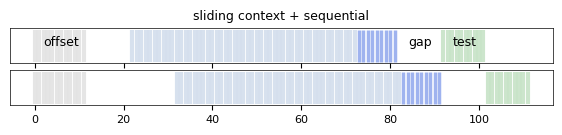

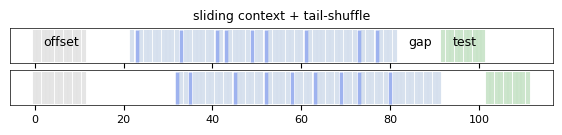

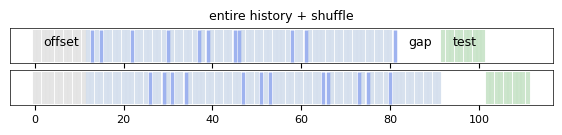

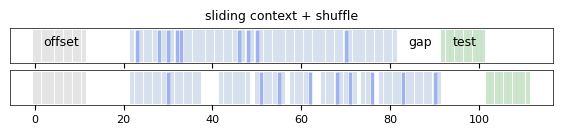

In [35]:
# ExitStack to combine multiple context managers. Also it looks badass
with ExitStack() as stack:
    stack.enter_context(plt.style.context('default'))
    stack.enter_context(plt.rc_context({'font.size': 8, 
                                        'axes.linewidth': 0.5}))    
    
    cvs = [SlidingWindowCV(start, test_size, train_size, eval_size, gap, 
                         eval_mode) for eval_mode,train_size in zip(['sequential','shuffle','shuffle', 'tail-shuffle'],
                                                                    [60, 60, -1, 60])]
    
    plot_cv_splits(cvs[0], offset, 100, 'sliding context + sequential', (7,1))
    plot_cv_splits(cvs[1], offset, 100, 'sliding context + tail-shuffle', (7,1))
    plot_cv_splits(cvs[2], offset, 100, 'entire history + shuffle', (7,1))
    plot_cv_splits(cvs[3], offset, 100, 'sliding context + shuffle', (7,1))

**Offset** serves to avoid too many NaN aggregate features.  
**Gap** between train and test is to exclude highly correlated regions, which might bias error estimates.  
Eval set (dark blue) is used for early stopping.

There are multiple variants of a typical sliding window CV scheme. 

1. On the top figure eval set is at the end of train set. A downside of this approach is that most recent observations are unavailable for training.
2. In the second scheme eval set is distributed randomly within train set. Context length is fixed.
3. A popular apprach is to utilize the entire history available up to this point. But: this makes it harder to compare performance on different folds; older, less relevant (and sometimes outdated) observations are still used for training.
4. The bottom figure is a hybrid method: train+eval size is fixed, but observations are sampled across the entire history. This allows for a fair comparison between folds and doesn't dismiss old observations completely.

To be clear, I don't know which one is optimal. I've chosen the last scheme, for the sake of experiment. In the end it worked well, but other approaches should be tried too. 

In [29]:
SlidingWindowCV??

Init signature:
SlidingWindowCV(
    start: int,
    test_size: int,
    train_size: int,
    eval_size: int | float,
    gap: int,
    eval_mode: str = 'sequential',
    n_reps: int = 1,
    last_fold: str = 'spread_out',
    seed=None,
    suppress_warnings: bool = True,
) -> None
Docstring:      <no docstring>
Source:        
class SlidingWindowCV:  

    def __init__(self, 
                 start: int,
                 test_size: int,
                 train_size: int,
                 eval_size: int | float,
                 gap: int,
                 eval_mode: str = 'sequential',
                 n_reps: int = 1,
                 last_fold: str = 'spread_out',
                 seed = None,
                 suppress_warnings: bool = True) -> None:    
        """Sliding window split generator a-la sklearn. More finely customizable
        See https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split for illustration 
        
        Parameters
        ------

### Training
[[To the top]](#Contents)

### Multistep-ahead Prediction Strategy

I train a single 30-steps-ahead model to predict timesteps $y_{t+1}...y_{t+30}$, e.g. to predict $y_{t+10}$ a model would use past data $x_{t-20-contextSize}...x_{t-20}$. To predict $y_{t+i}$ past data $x_{t-(i-30)-contextSize}...x_{t-(i-30)}$ would be used.

This way most recent data is not utilized for the nearest future predictions, which is dumb, but
- it works relatively well
- it doesn't accumulate error like recursive strategies
- it is *way* faster to train than an array of separate models for each horizon

Still, certain combinations of recursive and separate horizon strategies are possible and could be explored in the future. 


In [4]:
from utils.crossval import (
    ParamGridIter,
    SlidingWindowCV, 
)
from utils.train import fit

from sklearn.metrics import (
    mean_absolute_error,
    median_absolute_error,
)

In [5]:
df = pd.read_parquet('train.parquet')

cat_feats = ['hour','day','month', 'dayofweek',
             'pred_hour', 'pred_day', 'pred_month', 'pred_dayofweek']

zones   = [ col.split('_')[0] for col in df.columns if col.endswith('price')]
target  = 'FZYUAS18_price'
metrics = { 
    'mae': mean_absolute_error,
    'mdae': median_absolute_error, 
}

### Training Procedure
[[To the top]](#Contents)

In [38]:
fit??

Signature:
fit(
    df: pandas.core.frame.DataFrame,
    cv: utils.crossval.SlidingWindowCV,
    param_iter: Iterator[dict[str, int | float | str]],
    target: str,
    cat_feats: list[str],
    metrics: dict[str, typing.Callable],
    horiz: int,
    offset: int,
    eval_freq: int = -1,
    **kwargs,
) -> tuple[list, list[lightgbm.sklearn.LGBMRegressor]]
Docstring: <no docstring>
Source:   
def fit(df: pd.DataFrame,
        cv: SlidingWindowCV,
        param_iter: Iterator[dict[str, int|float|str]],
        target: str,
        cat_feats: list[str],
        metrics: dict[str, Callable],
        horiz: int,
        offset: int,
        eval_freq: int = -1,
       **kwargs) -> tuple[list, list[lgb.LGBMRegressor]]:
    
    inds = np.arange(offset, df.shape[0]-horiz)
    X, y = get_Xy(df, inds, horiz, target, kwargs.get('future_covar', True))
    baselines = { base_model: get_baseline(df, inds, horiz, target, base_model)
                 for base_model in param_iter.param_grid['base_mo

### CV Layout
[[To the top]](#Contents)  
I use two test folds of size 3000, eval is 15% of train

In [39]:
horiz = 30
offset = 24
test_size = 3000
eval_size = 0.15
gap = 0
n_splits = 2
n_reps = 1
start = df.shape[0]-horiz-offset-n_splits*test_size
train_size = start-gap
assert (df.shape[0]-offset-horiz-start)//test_size==n_splits, 'sizes don\'t match'

In [41]:
start, test_size, train_size

(17154, 3000, 17154)

In [42]:
cv = SlidingWindowCV(start, test_size, train_size, eval_size, gap, 'tail-shuffle', n_reps, 'spread_out')

### ParamGridIter
[[To the top]](#Contents)

`ParamGridIter` implements generator over hyperparam combinations. It's more flexible than `sklearn.GridSearch` because it allows to specify *exact* param combinations to go through, instead of iterating over entire Cartesian products 

In [6]:
param_grid = {
      'base_model': [
          'diff_ewm_0.2',
          'diff_ewm_0.4',
          'diff_ewm_0.6',
          'diff_ewm_0.8',
      ],
      'data_sample_strategy': ['bagging'],
      'objective':            ['mae'],
      'boosting':             ['gbdt'],
      'min_data_in_leaf':     [30,],
      'feature_fraction':     [0.1],
      'learning_rate':        [0.01, 0.05],
      'n_estimators':         [20000],
      'verbose':              [-1],
      'n_jobs':               [4],
      'n_early_stop_rounds/min_delta': [[300, 1e-3]],
      'bagging_freq/bagging_fraction': [[0, 0.6],],  
      'max_depth/num_leaves':          [[5, 25]],
     
}
pg = ParamGridIter(param_grid)

In [39]:
pg.to_dataframe(drop_const=True)

base_model  learning_rate
0  diff_ewm_0.2           0.01
1  diff_ewm_0.2           0.05
2  diff_ewm_0.4           0.01
3  diff_ewm_0.4           0.05
4  diff_ewm_0.6           0.01
5  diff_ewm_0.6           0.05
6  diff_ewm_0.8           0.01
7  diff_ewm_0.8           0.05

### Start
[[To the top]](#Contents)

In [44]:
cv_res_list, models = fit(df, cv, pg, target, cat_feats, metrics, horiz, offset, -1)

i_rep: 0 ; i_param: 0 ; i_outer: 0 
i_rep: 0 ; i_param: 1 ; i_outer: 0 
i_rep: 0 ; i_param: 2 ; i_outer: 0 
i_rep: 0 ; i_param: 3 ; i_outer: 0 
i_rep: 0 ; i_param: 0 ; i_outer: 1 
i_rep: 0 ; i_param: 1 ; i_outer: 1 
i_rep: 0 ; i_param: 2 ; i_outer: 1 
i_rep: 0 ; i_param: 3 ; i_outer: 1 


In [45]:
cv_res_df = pd.DataFrame(
        columns=['i_repeat', 'i_fold', 'i_param', 'params',] + \
    ['test_'+name for name in metrics.keys()],
    data=cv_res_list)

In [ ]:
cv_res_df.to_csv('cv_res_df_May8_0920.csv')

In [10]:
cv_res_df = pd.read_csv('cv_res_df_May8_0920.csv', index_col=0)

In [19]:
! ls -la models4

total 85860
drwxr-xr-x  2 root root     4096 May  8 09:49 .
drwxr-xr-x 11 root root     4096 May  8 09:49 ..
-rw-r--r--  1 root root      855 May  8 09:49 cv_res_df_Apr30_0400.csv
-rw-r--r--  1 root root    11277 May  8 09:49 logs_eval.json
-rw-r--r--  1 root root    11425 May  8 09:49 logs_test.json
-rw-r--r--  1 root root 43771418 May  8 09:48 m_00.txt
-rw-r--r--  1 root root 44106594 May  8 09:48 m_01.txt


In [11]:
cv_res_df

i_repeat  i_fold  i_param  \
0         0       0        0   
1         0       0        1   
2         0       0        2   
3         0       0        3   
4         0       1        0   
5         0       1        1   
6         0       1        2   
7         0       1        3   

                                              params    test_mae  test_mdae  
0  {'base_model': 'diff_ewm_0.7', 'data_sample_st...   54.098232  33.353881  
1  {'base_model': 'diff_ewm_0.7', 'data_sample_st...   52.619196  32.671501  
2  {'base_model': 'diff_ewm_0.9', 'data_sample_st...   53.912340  33.453954  
3  {'base_model': 'diff_ewm_0.9', 'data_sample_st...   52.643539  32.534358  
4  {'base_model': 'diff_ewm_0.7', 'data_sample_st...  116.702893  68.967754  
5  {'base_model': 'diff_ewm_0.7', 'data_sample_st...  114.756756  68.057658  
6  {'base_model': 'diff_ewm_0.9', 'data_sample_st...  115.796816  67.540304  
7  {'base_model': 'diff_ewm_0.9', 'data_sample_st...  114.879938  68.363886

In [46]:
cv_res_df.to_csv('cv_res_df_May8_0920.csv')

for i,m in enumerate(models):
    m.booster_.save_model(f'm_{i:02}_May8_0920.txt')

In [59]:
cv_res_df.to_csv('models1/cv_res_df.csv')

for i,m in enumerate(models):
    m.booster_.save_model(f'models1/m_{i:02}.txt')

### Intermediate Results I
[[To the top]](#Contents)

In [13]:
from utils.utils import (
    load_models_v2 as load_models,
    hist_metrics,
    summary,
)

In [7]:
load_models??

Signature: load_models(path: str) -> tuple[pandas.core.frame.DataFrame, list[lightgbm.basic.Booster]]
Source:   
def load_models_v2(path: str) -> tuple[pd.DataFrame, list[lgb.Booster]]:
    """
    Reads cv_res_df.csv and lightgbm models from
    specified directory. The directory has to contain
    exactly one .csv file.
    """
    csv_path = glob(f'{path}/*.csv')
    if len(csv_path)!=1:
        raise ValueError(f'Expected single .csv in target directory, got {csv_path}')
    
    cv_res_df = pd.read_csv(csv_path[0], index_col=0)
    models = []
    for i,path in enumerate(sorted(glob(f'{path}/*.txt'), 
                               key=lambda s: int(s[-6:-4]))):
        models.append(lgb.Booster(model_file=path))
        models[-1].params['base_model'] = eval(cv_res_df.iloc[i].params)['base_model']
    return cv_res_df, models
File:      /kaggle/working/site-packages/utils/utils.py
Type:      function

In [14]:
# model for median
cv_res_df_q05, models_q05 = load_models('models1')
# model for 0.025 and 0.975 quantiles
cv_res_df, models = load_models('models2')

There is a significant gap between test loss on the first and second folds, perhaps due to distributional shift (green lines mark medians)  

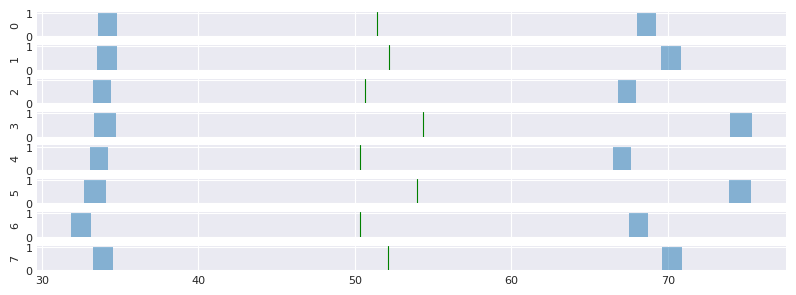

In [17]:
hist_metrics((8,3), cv_res_df_q05, 'test_mdae')

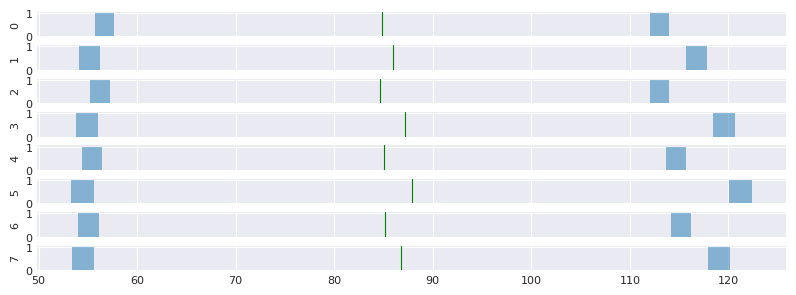

In [19]:
hist_metrics((8,3), cv_res_df_q05, 'test_mae')

In [12]:
sm = summary(cv_res_df_q05, ['median'])
fixed_cols = [col for col in sm.columns if sm[col].unique().shape[0]==1]

In [19]:
( sm
 .drop(columns = fixed_cols)
 .sort_values('test_mdae/median')
)

i_param  test_mae/median  test_mdae/median    base_model  learning_rate
6        6        85.111217         50.311401  diff_ewm_0.8           0.01
4        4        85.062408         50.348289  diff_ewm_0.6           0.01
2        2        84.609621         50.624372  diff_ewm_0.4           0.01
0        0        84.835122         51.404673  diff_ewm_0.2           0.01
7        7        86.760293         52.095147  diff_ewm_0.8           0.05
1        1        85.965046         52.185040  diff_ewm_0.2           0.05
5        5        87.861287         53.997280  diff_ewm_0.6           0.05
3        3        87.217820         54.365246  diff_ewm_0.4           0.05

Let's have a closer look at loss curves for the current best model. I'll train it from scratch, with evluation turned on (by default I keep it off to save time)  

In [10]:
eval(cv_res_df_q05.iloc[6].params)

{'base_model': 'diff_ewm_0.8',
 'data_sample_strategy': 'bagging',
 'objective': 'mae',
 'boosting': 'gbdt',
 'min_data_in_leaf': 30,
 'feature_fraction': 0.1,
 'learning_rate': 0.01,
 'n_estimators': 20000,
 'verbose': -1,
 'n_jobs': 4,
 'n_early_stop_rounds': 300,
 'min_delta': 0.001,
 'bagging_freq': 0,
 'bagging_fraction': 0.6,
 'max_depth': 5,
 'num_leaves': 25}

### Training (Evaluation On)
[[To the top]](#Contents)

In [11]:
param_grid = eval(cv_res_df_q05.iloc[6].params)
param_grid = {k:[v] for k,v in param_grid.items()}
pg = ParamGridIter(param_grid)

In [12]:
horiz = 30
offset = 24
test_size = 3000
eval_size = 0.15
gap = 0
n_splits = 2
n_reps = 1
start = df.shape[0]-horiz-offset-n_splits*test_size
train_size = start-gap
assert (df.shape[0]-offset-horiz-start)//test_size==n_splits, 'sizes don\'t match'

In [14]:
cv = SlidingWindowCV(start, test_size, train_size, eval_size, gap, 'tail-shuffle', n_reps, 'spread_out')

In [21]:
# suppress output bc sometimes lightgbm would spam warnings despite verbosity=-1
%%capture captured
eval_freq = 100
res = fit(df, cv, pg, target, cat_feats, metrics, horiz, offset, eval_freq)

In [23]:
cv_res_list, models, logs_eval, logs_test = res

In [24]:
cv_res_df = pd.DataFrame(
        columns=['i_repeat', 'i_fold', 'i_param', 'params',] + \
    ['test_'+name for name in metrics.keys()],
    data=cv_res_list)

In [26]:
cv_res_df

i_repeat  i_fold  i_param  \
0         0       0        0   
1         0       1        0   

                                              params    test_mae  test_mdae  
0  {'base_model': 'diff_ewm_0.8', 'data_sample_st...   52.407525  33.141847  
1  {'base_model': 'diff_ewm_0.8', 'data_sample_st...  114.589964  68.036043

In [ ]:
! mkdir models4

In [29]:
cv_res_df.to_csv('models4/cv_res_df.csv')

with open('models4/logs_eval.json', 'w') as f:
    json.dump(logs_eval, f)
    
with open('models4/logs_test.json', 'w') as f:
    json.dump(logs_test, f)
    
for i,m in enumerate(models):
    m.booster_.save_model(f'models4/m_{i:02}.txt')

In [27]:
with open('models4/logs_eval.json', 'r') as f:
    logs_eval = json.load(f)
    
with open('models4/logs_test.json', 'r') as f:
    logs_test = json.load(f)

In [31]:
from utils.utils import plot_eval_test
eval_freq = 100

### Loss Curves
[[To the top]](#Contents)

Standardized curves in the second row are the most instructive. Unscaled ones are on the top row.

For the first fold (used for early stopping) eval and test losses are perfectly aligned, implying good generalization. On the second fold test loss falls abruptly, reaches minimum around 400th iteration and then keeps raising, a clear sign of overfitting. 

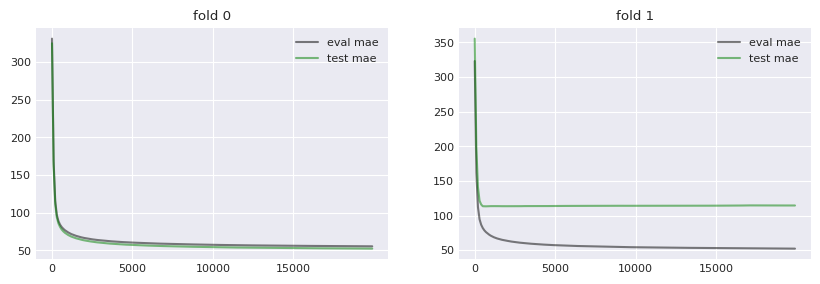

In [31]:
fig,ax=plt.subplots(1,2, figsize=(10,3))
plot_eval_test(ax[0], 'fold 0', ('eval mae', 'test mae'), eval_freq, logs_eval[0], logs_test[0], 0, False)
plot_eval_test(ax[1], 'fold 1', ('eval mae', 'test mae'), eval_freq, logs_eval[1], logs_test[1], 0, False)

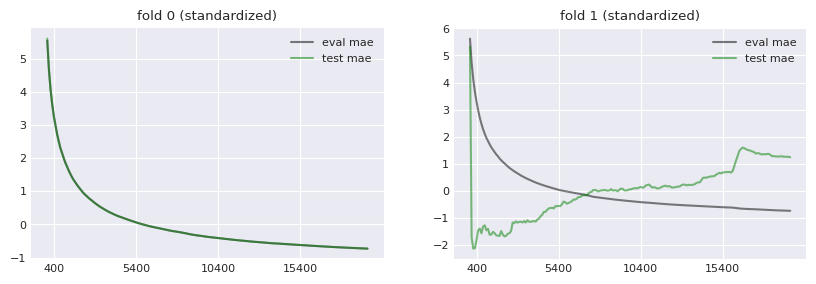

In [34]:
fig,ax=plt.subplots(1,2, figsize=(10,3))
plot_eval_test(ax[0], 'fold 0 (standardized)', 
               ('eval mae', 'test mae'), eval_freq, logs_eval[0], logs_test[0], 4, True)
plot_eval_test(ax[1], 'fold 1 (standardized)', 
               ('eval mae', 'test mae'), eval_freq, logs_eval[1], logs_test[1], 4, True)

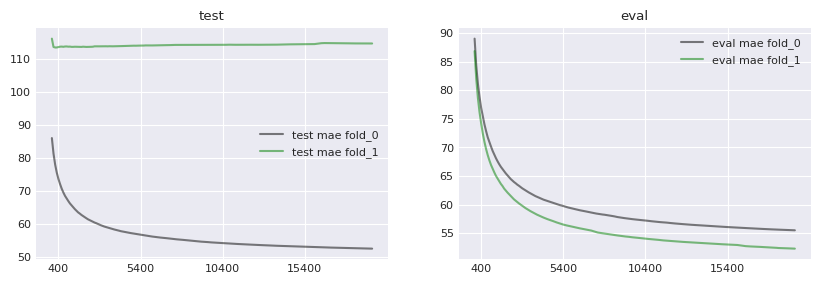

In [33]:
fig,ax=plt.subplots(1,2, figsize=(10,3))
plot_eval_test(ax[0], 'test', ('test mae fold_0', 'test mae fold_1'), eval_freq, logs_test[0], logs_test[1], 4, False)
plot_eval_test(ax[1], 'eval', ('eval mae fold_0', 'eval mae fold_1'), eval_freq, logs_eval[0], logs_eval[1], 4, False)

### Possible Remedies
[[To the top]](#Contents)

- To early stop earlier wouldn't work, because the loss gap is still huge
- Hyperparam search yield no good hyperparams

One obvious option is to shift train set forward to capture some portion of the test set. Next I train six models, each one shifted forward 200 rows more than the previous.

In [39]:
horiz = 30
offset = 24
eval_size = 0.15
gap = 0
n_splits = 1
n_reps = 1

In [64]:
res_list = []

for i in range(1,7):
    test_size = 3000-200*i
    start = df.shape[0]-horiz-offset-n_splits*test_size
    train_size = start-gap
    assert (df.shape[0]-offset-horiz-start)//test_size==n_splits, 'sizes don\'t match'
    
    eval_freq = -1
    cv = SlidingWindowCV(start, test_size, train_size, eval_size, gap, 'tail-shuffle', n_reps, 'spread_out')
    res = fit(df, cv, pg, target, cat_feats, metrics, horiz, offset, eval_freq)
    res_list.append(res)

i_rep: 0 ; i_param: 0 ; i_outer: 0 
i_rep: 0 ; i_param: 0 ; i_outer: 0 
i_rep: 0 ; i_param: 0 ; i_outer: 0 
i_rep: 0 ; i_param: 0 ; i_outer: 0 


In [79]:
cv_res_df = pd.DataFrame(
        columns=['i_repeat', 'i_fold', 'i_param', 'params',] + \
    ['test_'+name for name in metrics.keys()],
    data=[res[0][0] for res in res_list])

In [105]:
( cv_res_df
 .assign(test_size = [(3000-i*200) for i in range(1,7)])
 .drop(columns=['params'])
 .to_csv('cv_res_df_sliding_test.csv')
)

As expected, loss decreases. Notably, median absolute error doesn't change much, but mean absolute error does, which indicates that the model successfully learns to avoid extreme mistakes, but *a typical mistake* stays the same.

We need to use as little additional training examples as possible to avoid overfitting/ have some data to test on.

In [ ]:
cv_res_df_sliding_test = pd.read_csv('cv_res_df_sliding_test.csv')

In [108]:
cv_res_df_sliding_test

i_repeat  i_fold  i_param    test_mae  test_mdae  test_size
0         0       1        0  116.665222  66.773153       2800
1         0       1        0  110.990210  64.539045       2600
2         0       0        0  106.423452  60.942644       2400
3         0       0        0   93.170097  59.666296       2200
4         0       0        0   79.716908  60.137408       2000
5         0       0        0   69.480366  53.247851       1800

### Intermediate Results II
[[To the top]](#Contents)

After a few more rounds of hyperparam search with extended train set (extended by 1500 examples; the last test fold is now 1500 examples vs 3000 before; 4 folds in total) I've achieved the following performance (the searh was not exhaustive, so there is certainly a room for improvement).

The last fold loss is still greater than the rest, but it's been visibly reduced. Loss doesn't vary much across the folds 0-1-2, meaning that we don't overfit on the last fold. And it's safe to shrink test even more.

In [21]:
# CV layout
horiz = 30
offset = 24
test_size = 1500
eval_size = 0.15
gap = 0
n_splits = 4
n_reps = 1
start = df.shape[0]-horiz-offset-n_splits*test_size
train_size = start-gap
assert (df.shape[0]-offset-horiz-start)//test_size==n_splits, 'sizes don\'t match'

In [28]:
cv_res_df = pd.read_csv('models7/cv_res_df.csv', index_col=0)

In [74]:
cv_res_df.drop(columns='params')

i_repeat  i_fold  i_param   test_mae  test_mdae
0         0       0        0  59.960112  36.009511
1         0       1        0  58.917200  35.528213
2         0       2        0  55.926043  33.206216
3         0       3        0  61.195956  50.568961

In [76]:
eval(cv_res_df.iloc[0].params)

{'base_model': 'diff_ewm_0.8',
 'data_sample_strategy': 'bagging',
 'objective': 'mae',
 'boosting': 'gbdt',
 'min_data_in_leaf': 30,
 'feature_fraction': 0.05,
 'learning_rate': 0.01,
 'n_estimators': 17000,
 'verbose': -1,
 'n_jobs': 4,
 'n_early_stop_rounds': 300,
 'min_delta': 0.01,
 'bagging_freq': 0,
 'bagging_fraction': 0.6,
 'max_depth': 5,
 'num_leaves': 25}

### Uncertainty
[[To the top]](#Contents)

To model prediction uncertainty I train two additional models with quantile loss (0.025 and 0.975 quantiles). Here's one of the hyperparam batches 

In [79]:
cv_res_df = pd.read_csv('models5/cv_res_df.csv')
sm = summary(cv_res_df, ['median'])
fixed_cols = [col for col in sm.columns if sm[col].unique().shape[0]==1]

In [35]:
( sm
 .drop(columns = fixed_cols)
 .sort_values('test_mdae/median')
)

i_param  test_mae/median  test_mdae/median    base_model  alpha  \
3         3       177.919262        165.134317  diff_ewm_0.7  0.975   
7         7       181.445609        169.183377  diff_ewm_0.9  0.975   
11       11       185.672918        171.530361      last_val  0.975   
6         6       182.721836        172.171980  diff_ewm_0.9  0.975   
2         2       183.474226        173.250802  diff_ewm_0.7  0.975   
10       10       186.129867        174.700970      last_val  0.975   
0         0       185.184873        179.089374  diff_ewm_0.7  0.025   
4         4       194.086069        190.097311  diff_ewm_0.9  0.025   
8         8       197.259248        192.447657      last_val  0.025   
9         9       199.911414        198.028707      last_val  0.025   
5         5       222.155585        217.317684  diff_ewm_0.9  0.025   
1         1       227.295522        224.546428  diff_ewm_0.7  0.025   

    feature_fraction  
3               0.20  
7               0.20  
11              0.20  
6               0.05  
2               0.05  
10              0.05  
0               0.05  
4               0.05  
8               0.05  
9               0.20  
5               0.20  
1               0.20

### Prediction Plots
[[To the top]](#Contents)

In [34]:
from utils.utils import display_predict

### Predictions: Last (4th) Fold
[[To the top]](#Contents)

In [33]:
model_q025 = load_models('models5')[1][0]
model_q975 = load_models('models6')[1][3]
model_q50  = load_models('models7')[1][3]

In [36]:
# CV layout
horiz = 30
offset = 24
test_size = 1500
eval_size = 0.15
gap = 0
n_splits = 4
n_reps = 1
start = df.shape[0]-horiz-offset-n_splits*test_size

/tmp/ipykernel_33/3022117584.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax=plt.subplots(figsize=figsize)


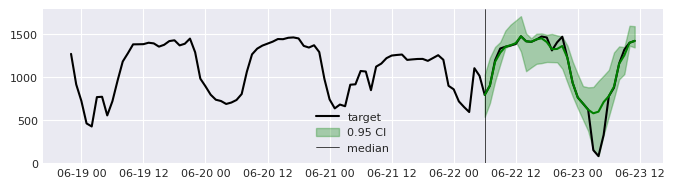

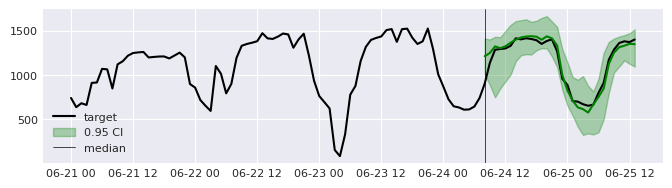

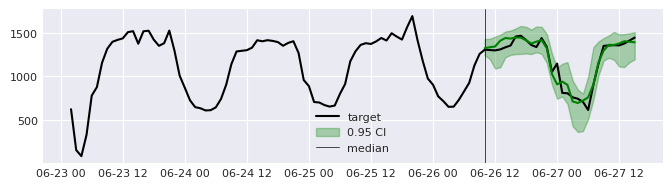

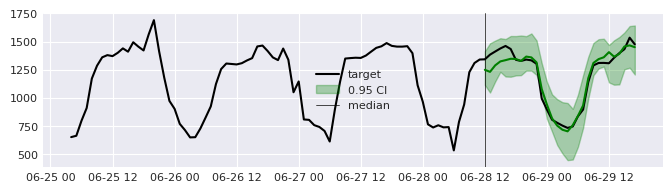

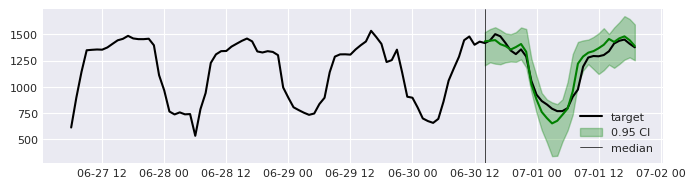

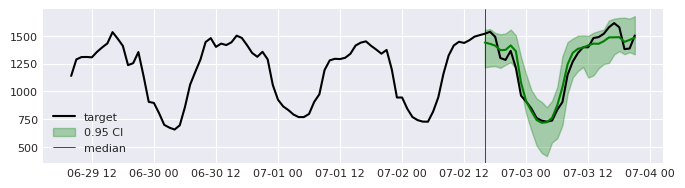

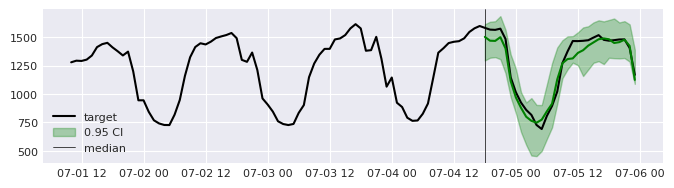

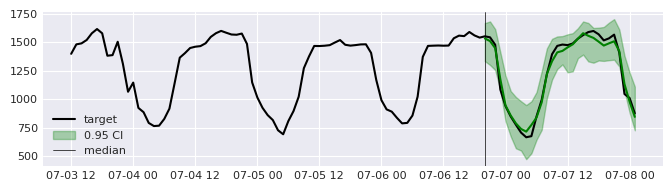

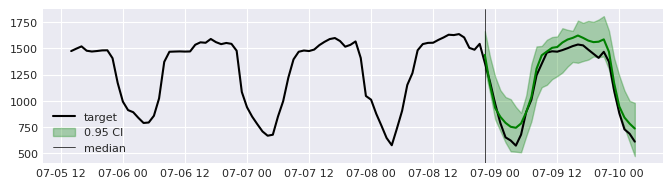

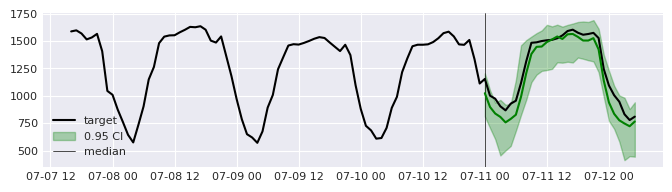

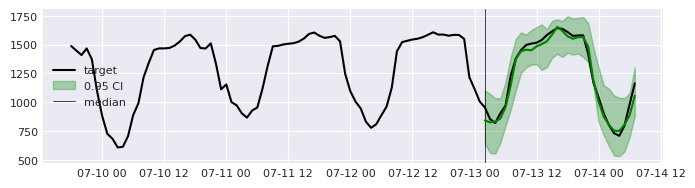

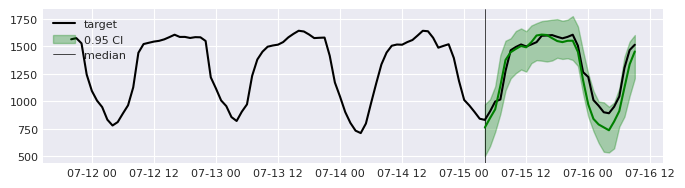

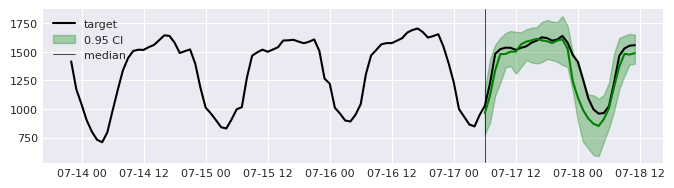

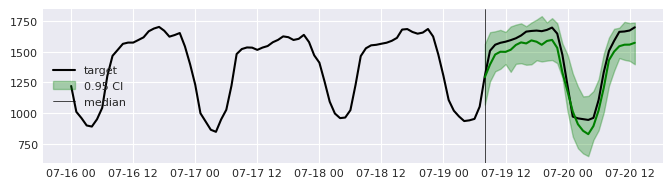

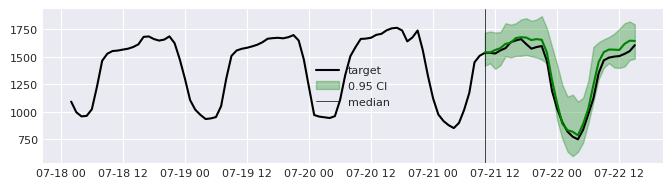

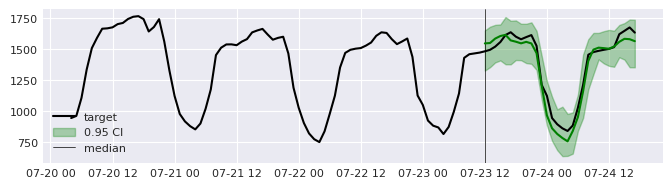

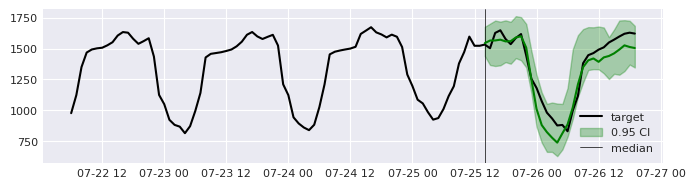

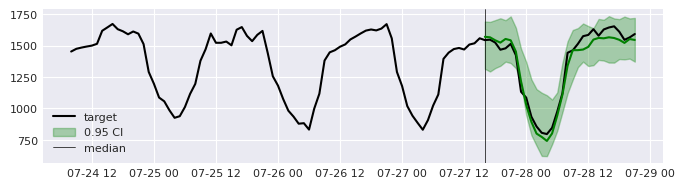

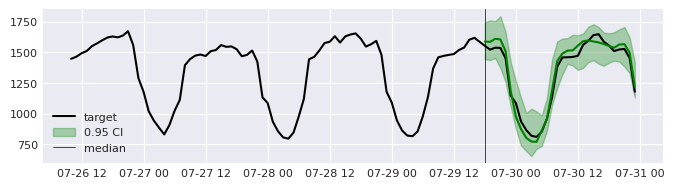

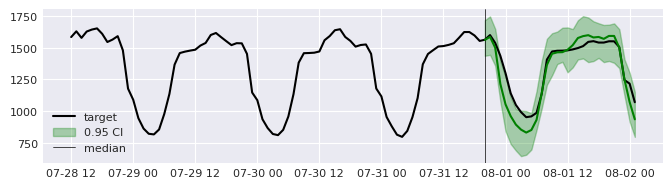

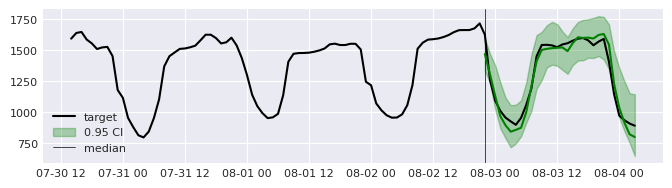

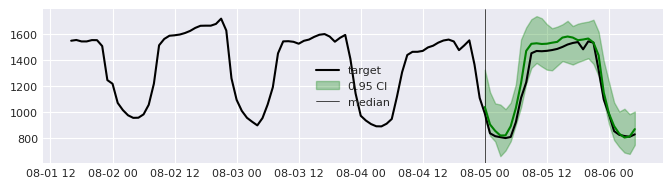

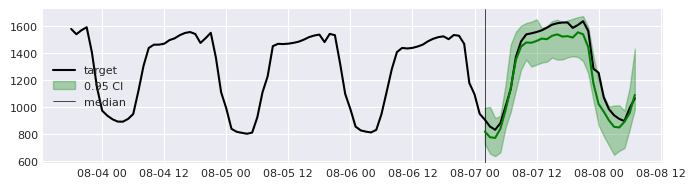

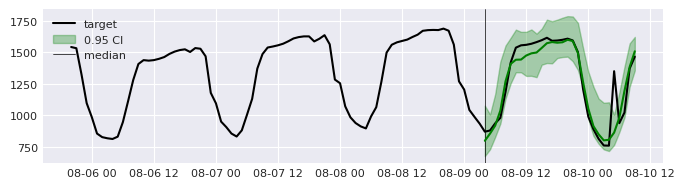

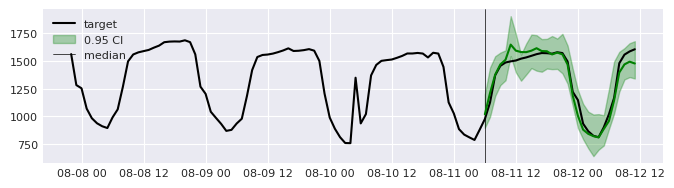

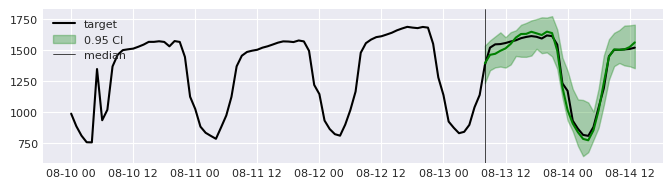

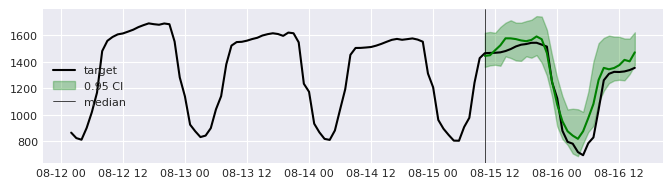

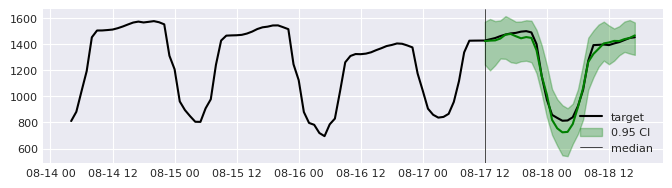

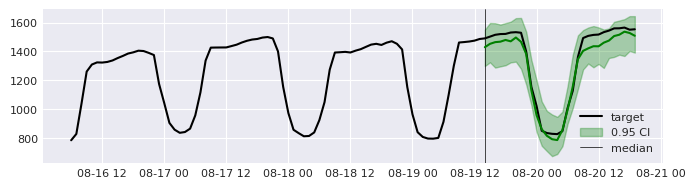

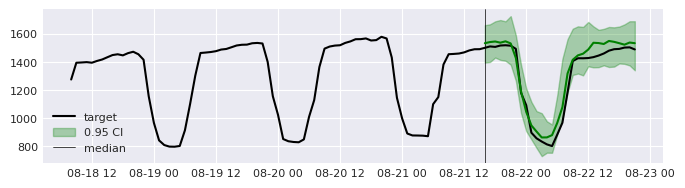

In [37]:
for i in range(offset+start+test_size*3, offset+start+4*test_size-horiz, 50):
    display_predict(df, 
                    [model_q025, model_q50, model_q975,],
                    ['0.95 CI', 'median'],
                    i, horiz, target, as_quantiles=True, margin=80, figsize=(8,2), 
                    )

### Predictions: 3rd Fold
[[To the top]](#Contents)

In [45]:
model_q50_2  = load_models('models7')[1][2]

/tmp/ipykernel_33/4021252965.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax=plt.subplots(figsize=figsize)


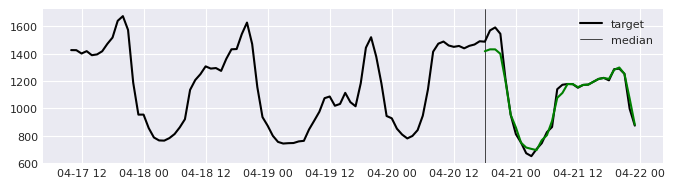

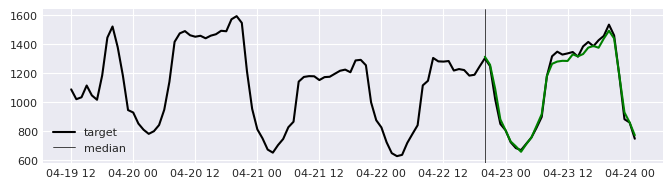

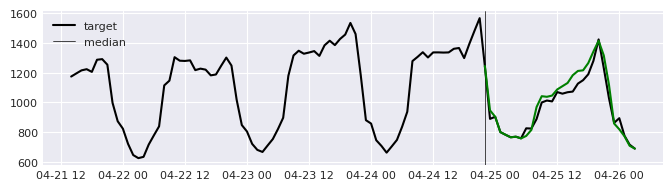

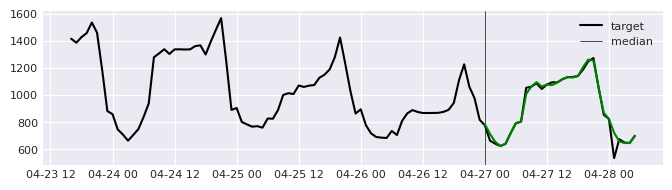

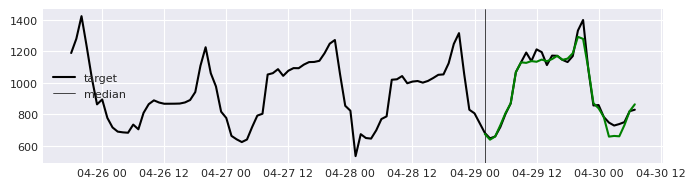

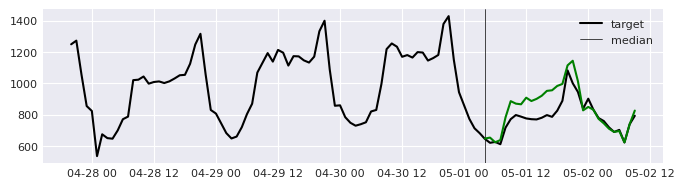

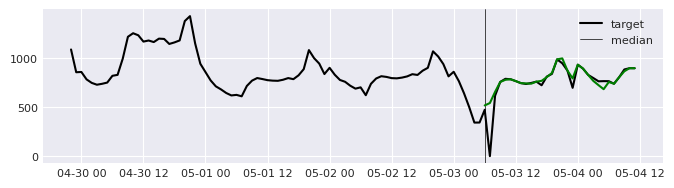

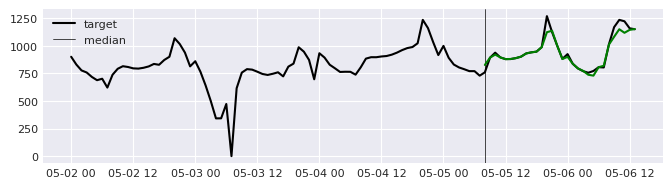

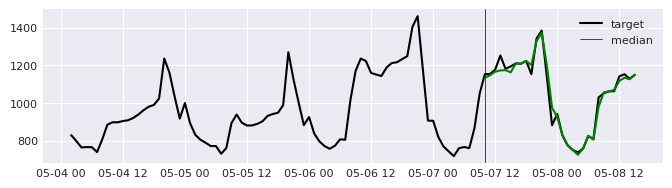

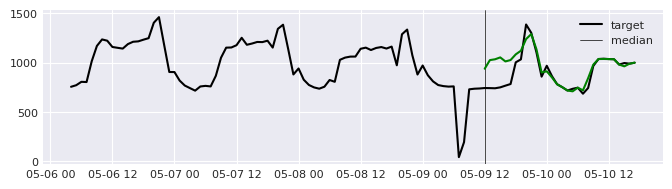

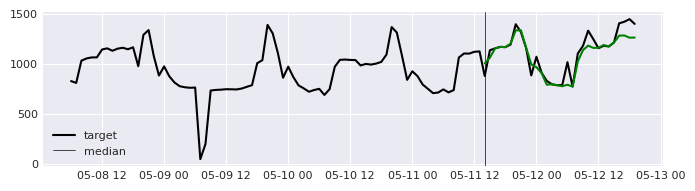

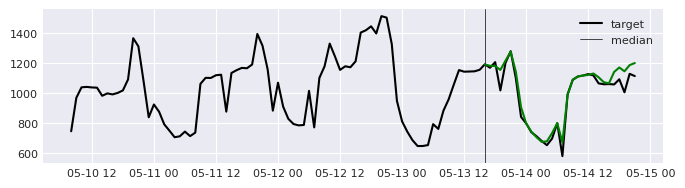

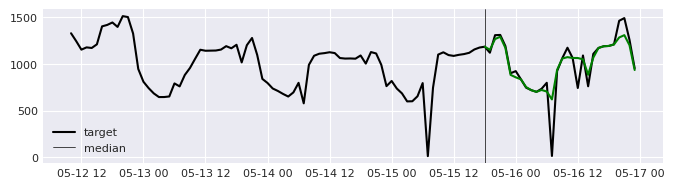

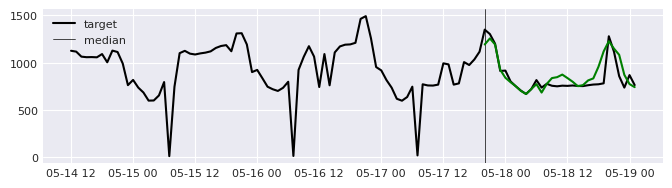

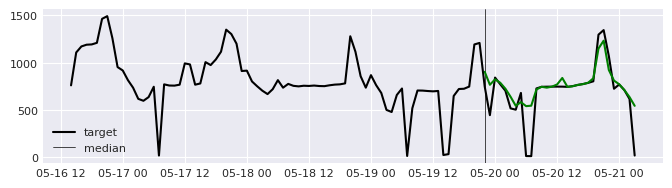

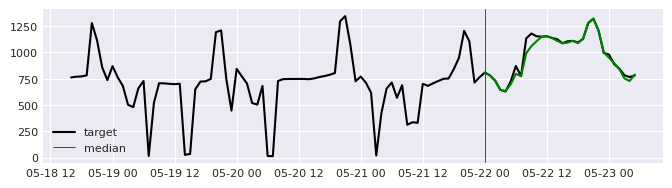

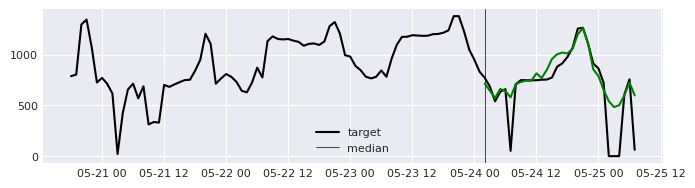

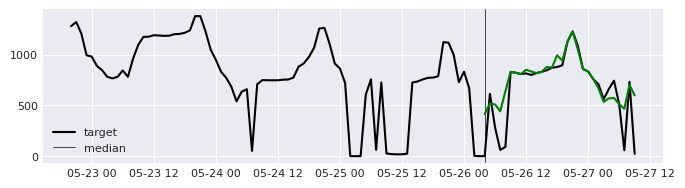

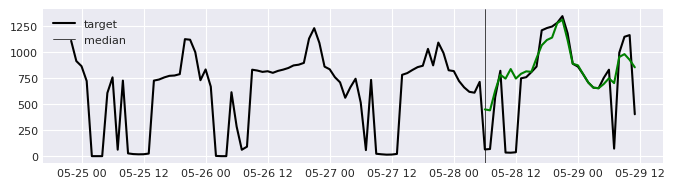

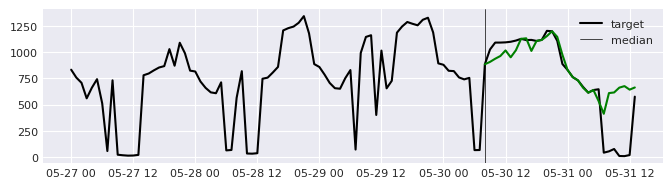

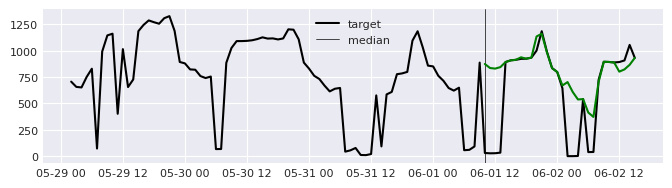

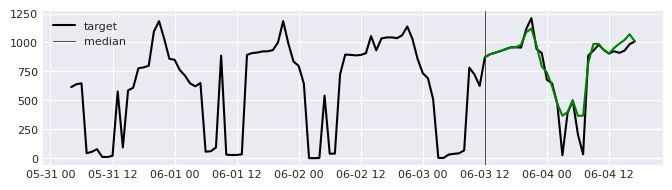

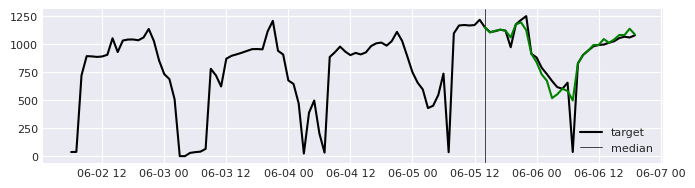

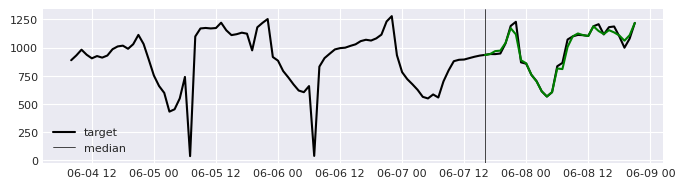

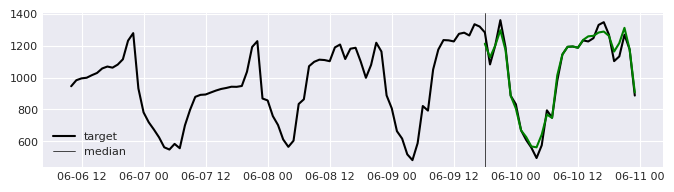

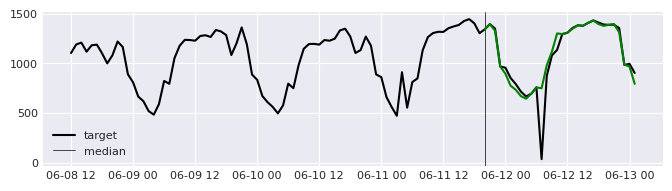

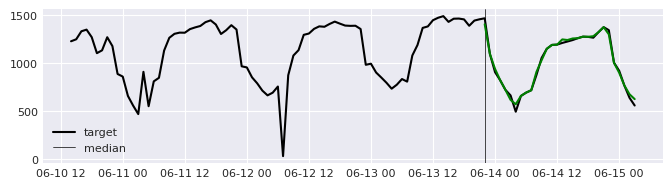

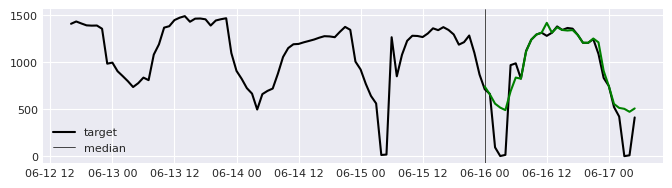

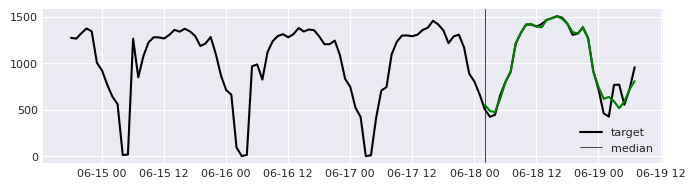

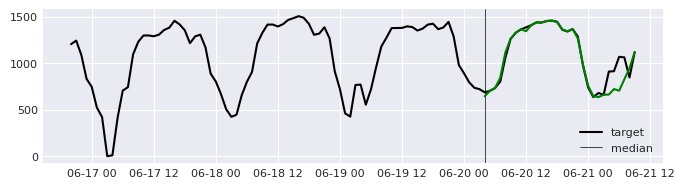

In [47]:
for i in range(offset+start+test_size*2, offset+start+test_size*3, 50):
    display_predict(df, 
                    [model_q50_2],
                    ['median'],
                    i, horiz, target, as_quantiles=False, margin=80, figsize=(8,2), 
                    )

### Predictions: 2nd Fold
[[To the top]](#Contents)

In [52]:
model_q50_2  = load_models('models7')[1][1]

/tmp/ipykernel_33/2107446034.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax=plt.subplots(figsize=figsize)


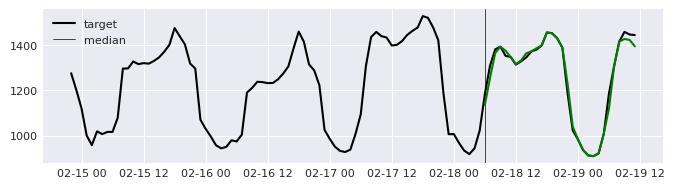

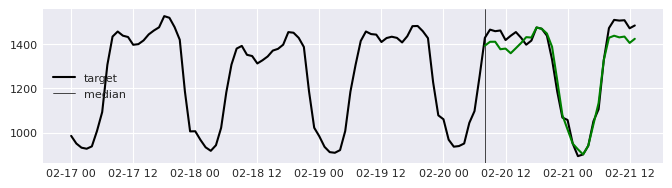

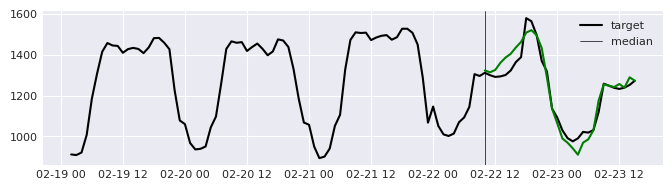

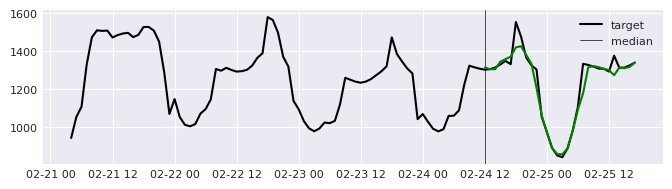

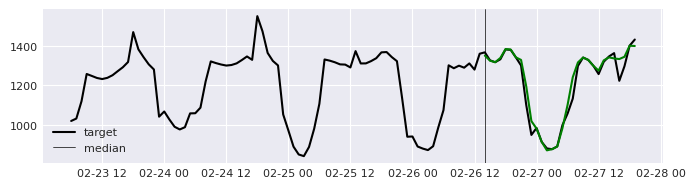

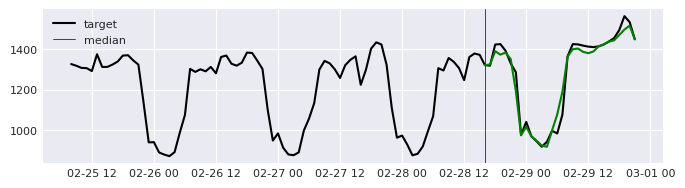

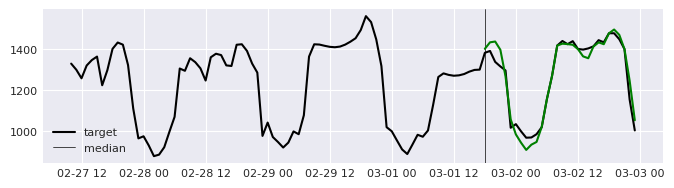

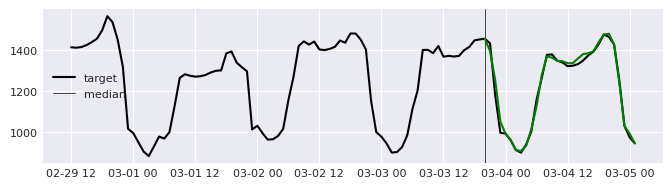

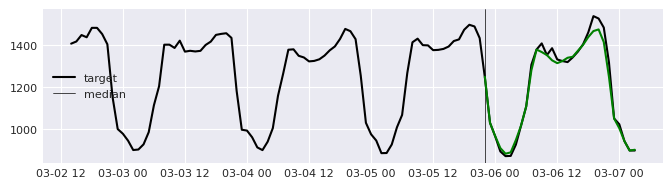

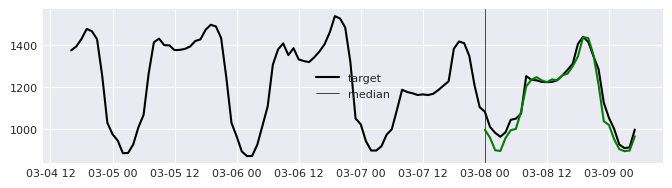

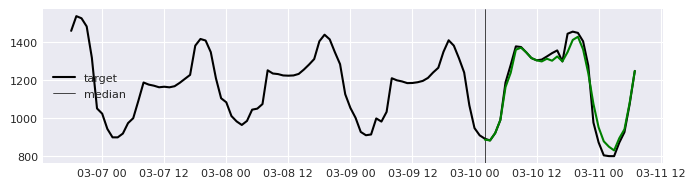

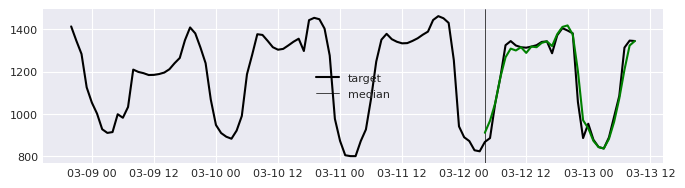

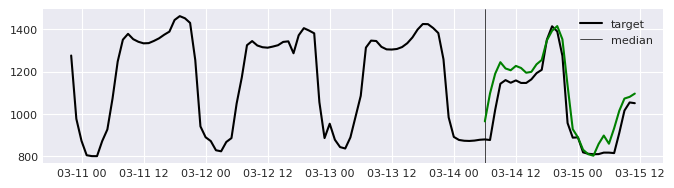

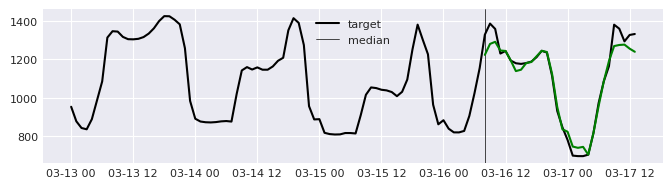

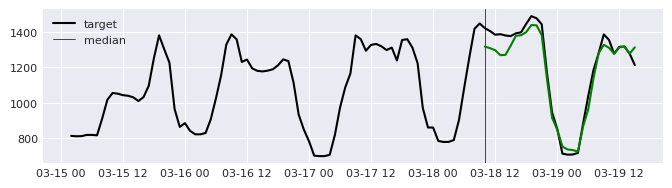

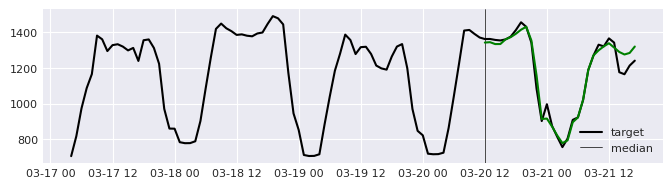

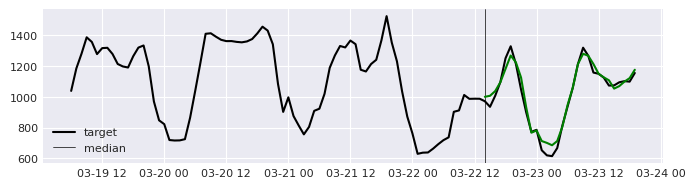

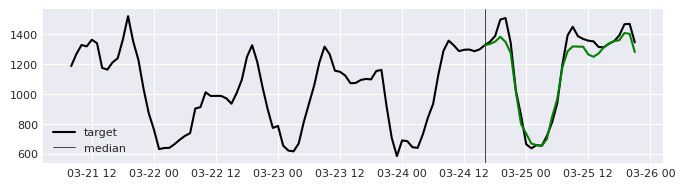

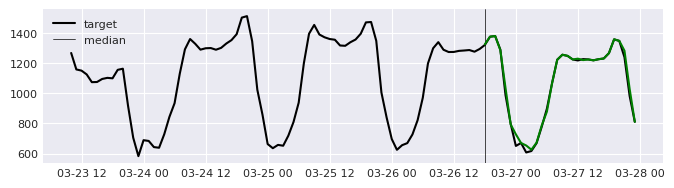

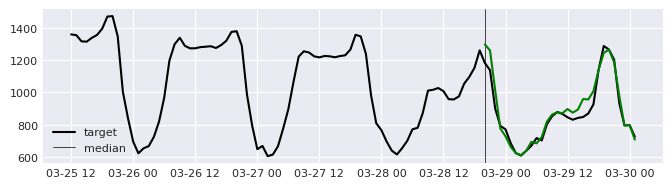

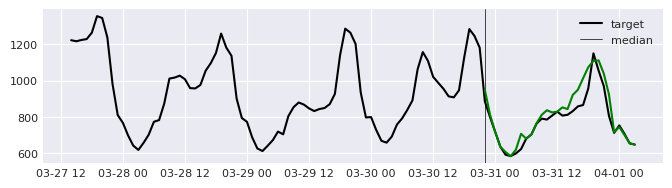

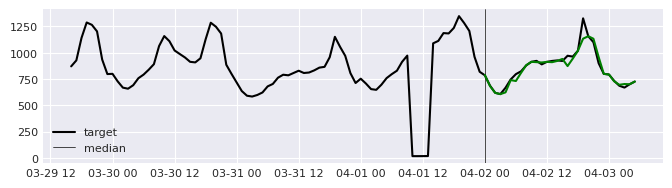

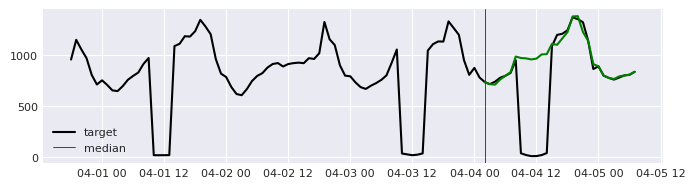

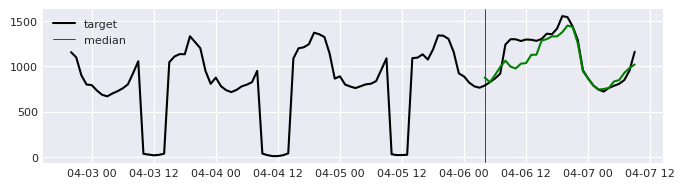

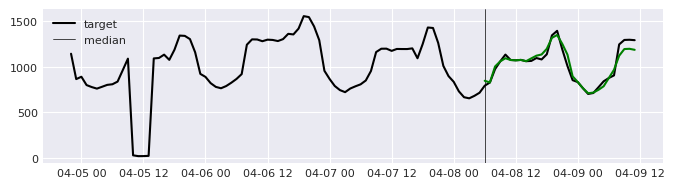

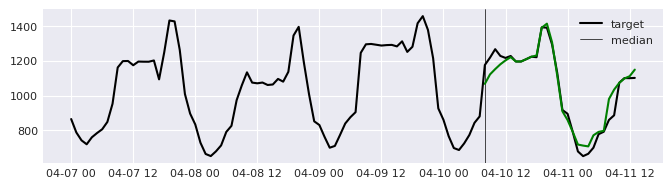

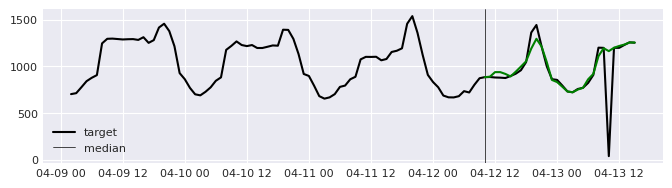

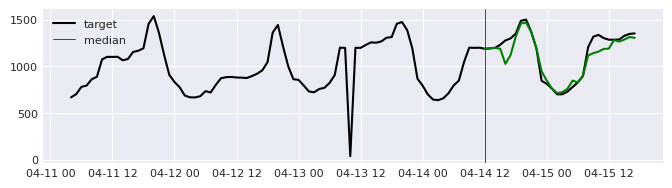

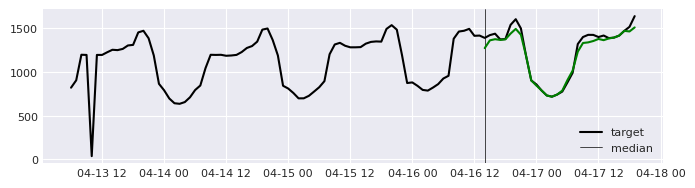

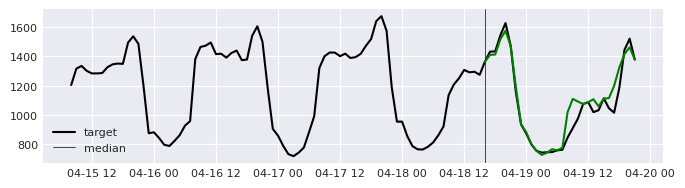

In [53]:
for i in range(offset+start+test_size, offset+start+test_size*2, 50):
    display_predict(df, 
                    [model_q50_2],
                    ['median'],
                    i, horiz, target, as_quantiles=False, margin=80, figsize=(8,2), 
                    )

### Predictions: 1st Fold
[[To the top]](#Contents)

In [48]:
model_q50_2  = load_models('models7')[1][0]

/tmp/ipykernel_33/4021252965.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax=plt.subplots(figsize=figsize)


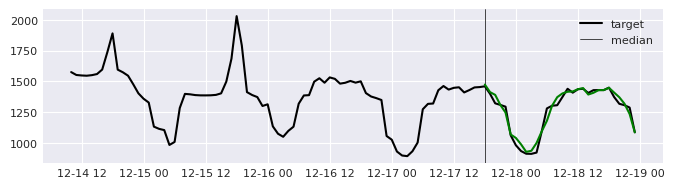

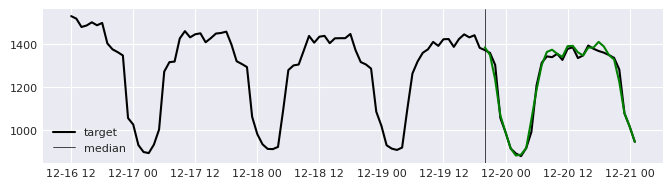

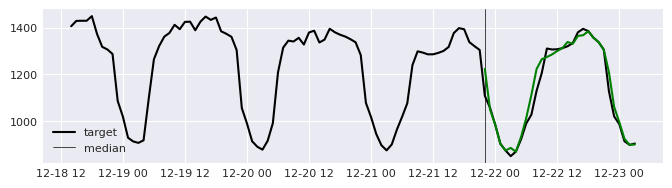

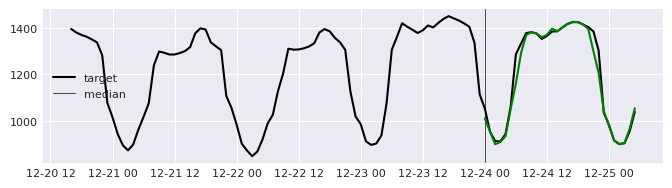

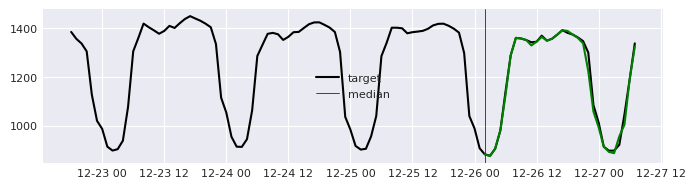

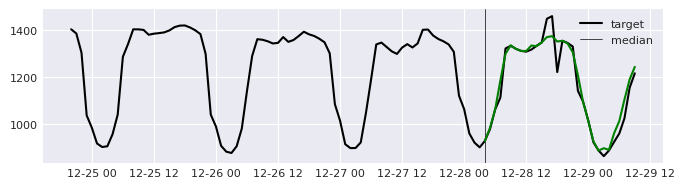

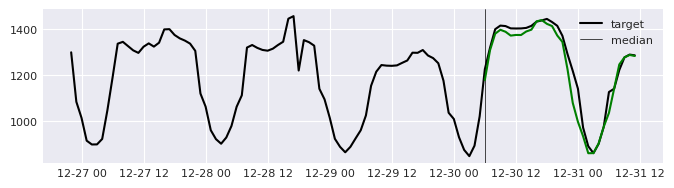

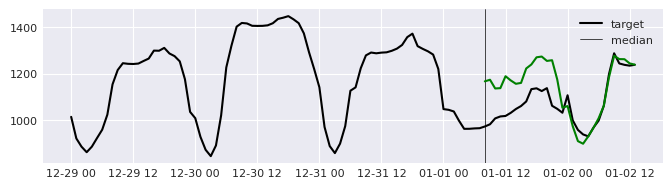

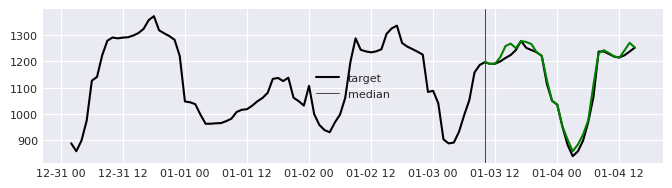

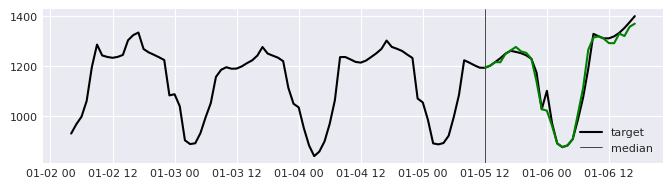

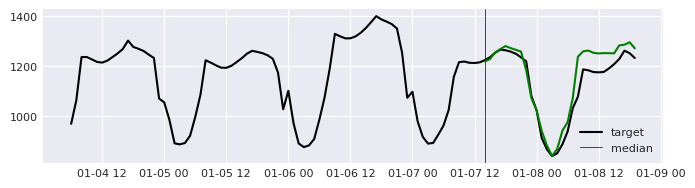

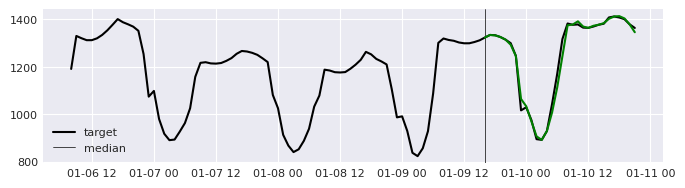

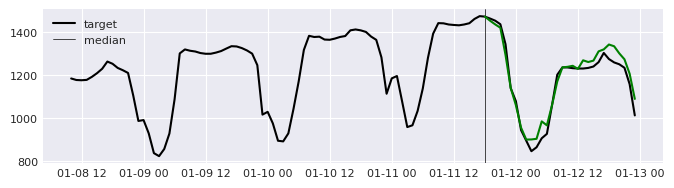

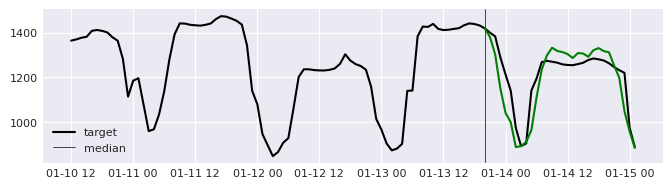

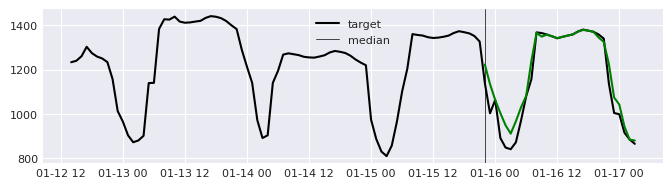

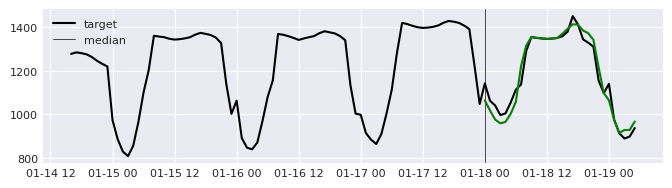

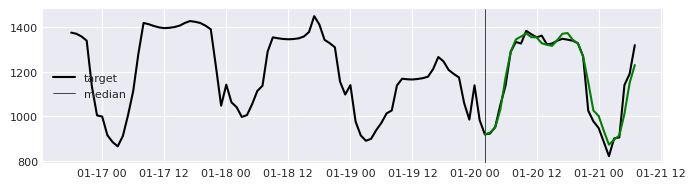

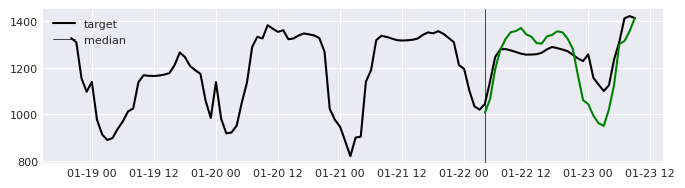

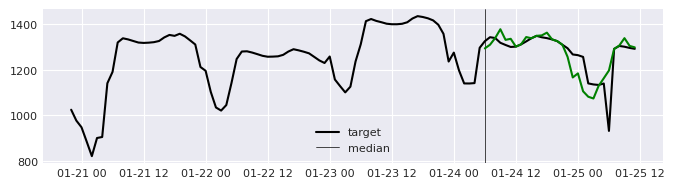

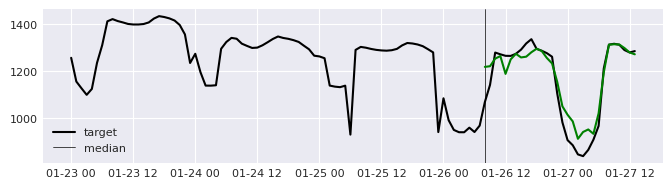

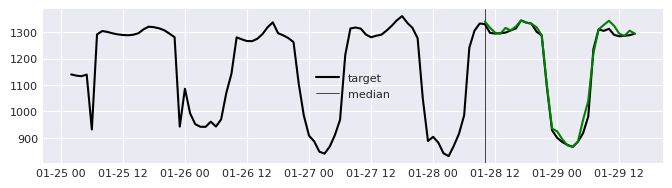

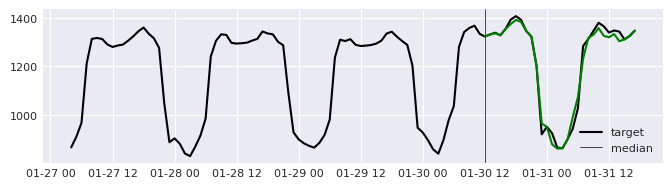

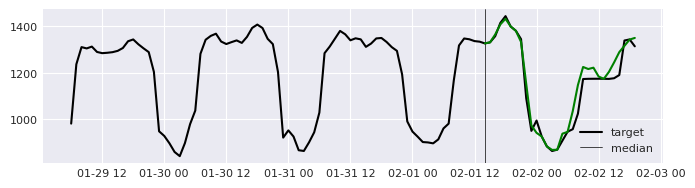

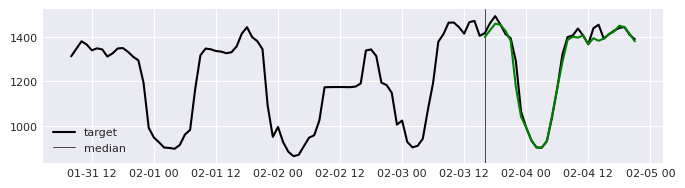

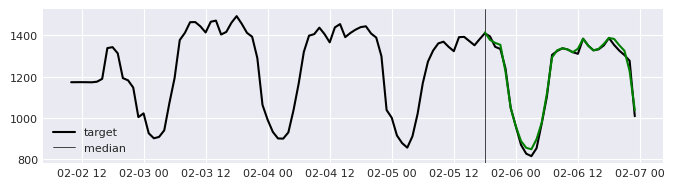

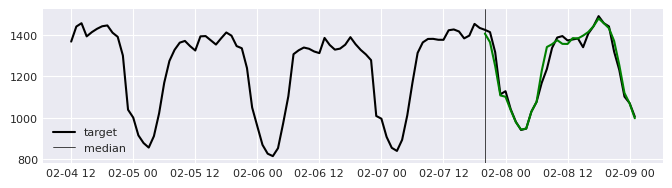

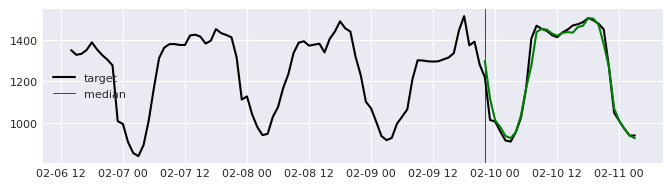

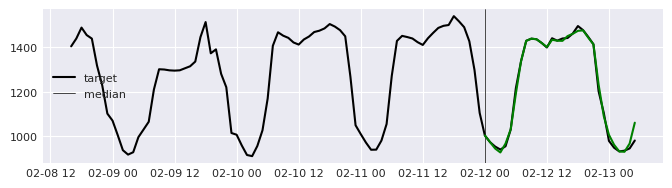

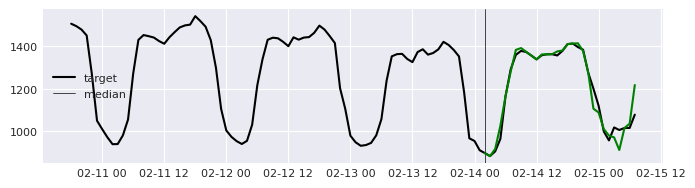

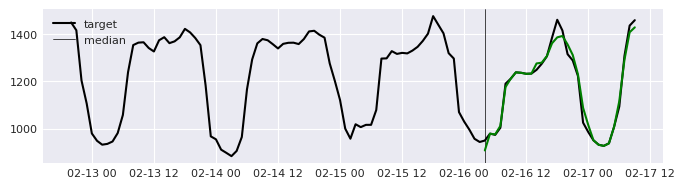

In [49]:
for i in range(offset+start, offset+start+test_size, 50):
    display_predict(df, 
                    [model_q50_2],
                    ['median'],
                    i, horiz, target, as_quantiles=False, margin=80, figsize=(8,2), 
                    )

### Future Work
[[To the top]](#Contents)

Prediction quality is decent overall, but sudden price drops (to zero) aren't captured. Some unexpected transitions also remain difficult.

What could be done?
1. There are multiple price series. I aimed at predicting only one of them, but others could be used for data augmentation
2. Sudden price drops - if important - could be tackled through a separate model, trained specifically to predict such drops (by weighting/ making objective more sensitive to them) 
3. Different multi-step prediction strategies
4. New features. `tsfresh` features were only applied to the target price series. They could be extended to others 
5. Different CV layouts: see overview of [CV Strategies](#Cross-Validation-Strategy) above  
6. More hyperparam search, obviously